In [1]:
%load_ext Cython

In [2]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as pyplot
import optuna as op
%matplotlib inline
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Utils.createURM import createURM
from Utils.createICM import createICM
from Utils.combineURMICM import combine

In [3]:
URM = createURM()
#ICM = createICM()

/Users/matteopancini/PycharmProjects/recsys-challenge-2022-Pancini-Vitali/Utils/createURM.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('/Users/matteopancini/PycharmProjects/recsys-challenge-2022-Pancini-Vitali/Input/interactions_and_impressions.csv')


In [4]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

In [5]:
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 759 ( 1.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 315 ( 0.8%) Users that have less than 1 test interactions


## Number of Neighbors

In [27]:
x_tick = [10, 25, 40, 50, 100, 500]
MAP_per_k = []

for topK in x_tick:

    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_k.append(result_df.loc[10]["MAP"])

ItemKNNCFRecommender: URM Detected 2 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1103.14 column/sec. Elapsed time 22.22 sec
EvaluatorHoldout: Processed 38925 (100.0%) in 19.01 sec. Users per second: 2047
ItemKNNCFRecommender: URM Detected 2 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1190.56 column/sec. Elapsed time 20.58 sec
EvaluatorHoldout: Processed 38925 (100.0%) in 19.31 sec. Users per second: 2016
ItemKNNCFRecommender: URM Detected 2 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1179.81 column/sec. Elapsed time 20.77 sec
EvaluatorHoldout: Processed 38925 (100.0%) in 19.47 sec. Users per second: 2000
ItemKNNCFRecommender: URM Detected 2 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting

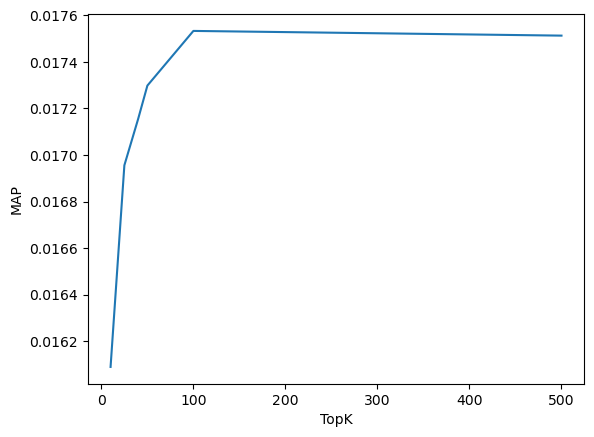

In [28]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

Let's take topK=23

## Shrinkage

In [12]:
x_tick = [0, 10, 50, 100, 200]
MAP_per_shrinkage = []

for shrink in x_tick:

    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=100)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

ItemKNNCFRecommender: URM Detected 7 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1118.07 column/sec. Elapsed time 21.92 sec
EvaluatorHoldout: Processed 38971 (100.0%) in 21.72 sec. Users per second: 1794
ItemKNNCFRecommender: URM Detected 7 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1072.05 column/sec. Elapsed time 22.86 sec
EvaluatorHoldout: Processed 38971 (100.0%) in 22.28 sec. Users per second: 1750
ItemKNNCFRecommender: URM Detected 7 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1078.73 column/sec. Elapsed time 22.72 sec
EvaluatorHoldout: Processed 38971 (100.0%) in 23.66 sec. Users per second: 1647
ItemKNNCFRecommender: URM Detected 7 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting

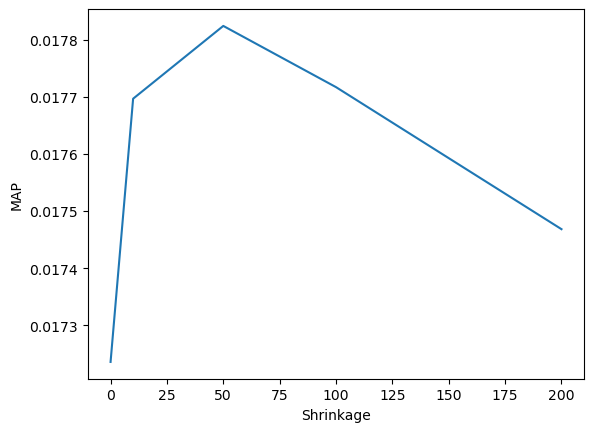

In [13]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

Let's take shrinkage = 100

## Testing of reccomenders

In [14]:
collaborative_recommender1 = ItemKNNCFRecommender(URM_train)
# collaborative_recommender1.fit(shrink=10, topK=20)

collaborative_recommender2 = ItemKNNCFRecommender(URM_train)
# collaborative_recommender2.fit(shrink=100, topK=25)

collaborative_MAP1 = []
collaborative_MAP2 = []

x_tick = []

for topK in [80, 100]:
    for shrink in [25, 50]:
        x_tick.append("topk {}, shrink {}".format(topK, shrink))

        collaborative_recommender1.fit(shrink=shrink, topK=topK)
        collaborative_recommender2.fit(shrink=shrink, topK=topK)

        result_df, _ = evaluator_test.evaluateRecommender(collaborative_recommender1)
        collaborative_MAP1.append(result_df.loc[10]["MAP"])

        result_df, _ = evaluator_test.evaluateRecommender(collaborative_recommender2)
        collaborative_MAP2.append(result_df.loc[10]["MAP"])

ItemKNNCFRecommender: URM Detected 7 ( 0.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 7 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1094.74 column/sec. Elapsed time 22.39 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1167.04 column/sec. Elapsed time 21.00 sec
EvaluatorHoldout: Processed 40081 (100.0%) in 22.85 sec. Users per second: 1754
EvaluatorHoldout: Processed 40081 (100.0%) in 22.68 sec. Users per second: 1767
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1169.16 column/sec. Elapsed time 20.96 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1146.43 column/sec. Elapsed time 21.38 sec
EvaluatorHoldout: Processed 40081 (100.0%) in 23.27 sec. Users per second: 1723
EvaluatorHoldout: Processed 40081 (100.0%) in 22.86 sec. U

In [1]:
pyplot.plot(x_tick, collaborative_MAP1, label="Collaborative1")
pyplot.plot(x_tick, collaborative_MAP2, label="Collaborative2")

pyplot.ylabel('Similarity')
pyplot.xlabel('Sorted values')
pyplot.legend()
pyplot.show()

NameError: name 'pyplot' is not defined

## OPTUNA optimization

In [30]:
recommender = ItemKNNCFRecommender(URM_train)

def objective(trial):
    topK = trial.suggest_float("topK", 80, 90)
    shrink = trial.suggest_float("shrink", 10, 15)
    recommender.fit(topK=int(topK), shrink=shrink)
    result_dict, _ = evaluator_validation.evaluateRecommender(recommender)

    return result_dict.loc[10]["MAP"]

ItemKNNCFRecommender: URM Detected 2 ( 0.0%) users with no interactions.


In [6]:
# objective = represents the function that we need to minimize
# trial = optuna parameter that tries random values in a certain interval
recommender = ItemKNNCFRecommender(URM_train)
from optuna.samplers import TPESampler


def objective(trial):
    topK = trial.suggest_int("topK", 175, 195)
    shrink = trial.suggest_float("shrink", 50, 56)
    recommender.fit(topK=topK, shrink=shrink)
    result_dict, _ = evaluator_validation.evaluateRecommender(recommender)

    return result_dict.loc[10]["MAP"]

In [7]:
import optuna

study = op.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(
        n_startup_trials=2, n_warmup_steps=5, interval_steps=3
    ), sampler=TPESampler())
study.optimize(objective, n_trials=10)

[I 2022-11-06 20:18:07,127] A new study created in memory with name: no-name-87ea820f-7df0-41d0-bc18-13e6122fff94


Similarity column 24507 (100.0%), 8260.94 column/sec. Elapsed time 2.97 sec
EvaluatorHoldout: Processed 40870 (100.0%) in 21.64 sec. Users per second: 1889


[I 2022-11-06 20:18:31,832] Trial 0 finished with value: 0.018929714231340926 and parameters: {'topK': 178, 'shrink': 55.9401495657752}. Best is trial 0 with value: 0.018929714231340926.


Similarity column 24507 (100.0%), 8468.71 column/sec. Elapsed time 2.89 sec
EvaluatorHoldout: Processed 40870 (100.0%) in 22.40 sec. Users per second: 1824


[I 2022-11-06 20:18:57,235] Trial 1 finished with value: 0.018976079788411135 and parameters: {'topK': 192, 'shrink': 51.894537243015705}. Best is trial 1 with value: 0.018976079788411135.


Similarity column 24507 (100.0%), 8483.25 column/sec. Elapsed time 2.89 sec
EvaluatorHoldout: Processed 40870 (100.0%) in 22.24 sec. Users per second: 1838


[I 2022-11-06 20:19:22,461] Trial 2 finished with value: 0.01899087311296712 and parameters: {'topK': 194, 'shrink': 52.04558832940477}. Best is trial 2 with value: 0.01899087311296712.


Similarity column 24507 (100.0%), 8563.78 column/sec. Elapsed time 2.86 sec
EvaluatorHoldout: Processed 40870 (100.0%) in 22.24 sec. Users per second: 1837


[I 2022-11-06 20:19:47,655] Trial 3 finished with value: 0.01898789425239099 and parameters: {'topK': 193, 'shrink': 52.08287107783844}. Best is trial 2 with value: 0.01899087311296712.


Similarity column 24507 (100.0%), 8543.08 column/sec. Elapsed time 2.87 sec
EvaluatorHoldout: Processed 40870 (100.0%) in 21.85 sec. Users per second: 1871


[I 2022-11-06 20:20:12,439] Trial 4 finished with value: 0.01895922514670945 and parameters: {'topK': 187, 'shrink': 51.693981214445174}. Best is trial 2 with value: 0.01899087311296712.


/var/folders/tt/9v6608x550n51759gpcrffsc0000gn/T/ipykernel_48611/3963308714.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)
/var/folders/tt/9v6608x550n51759gpcrffsc0000gn/T/ipykernel_48611/3963308714.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

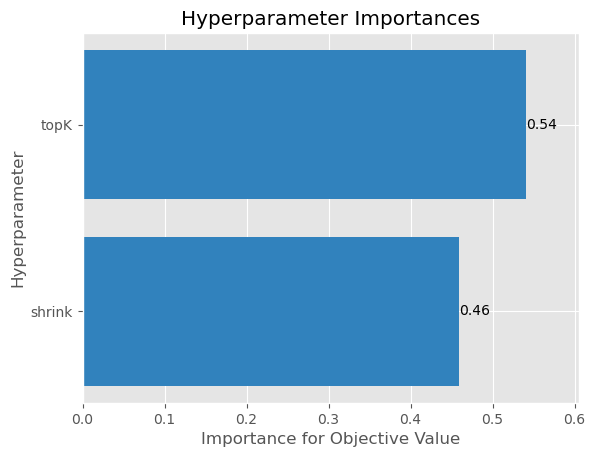

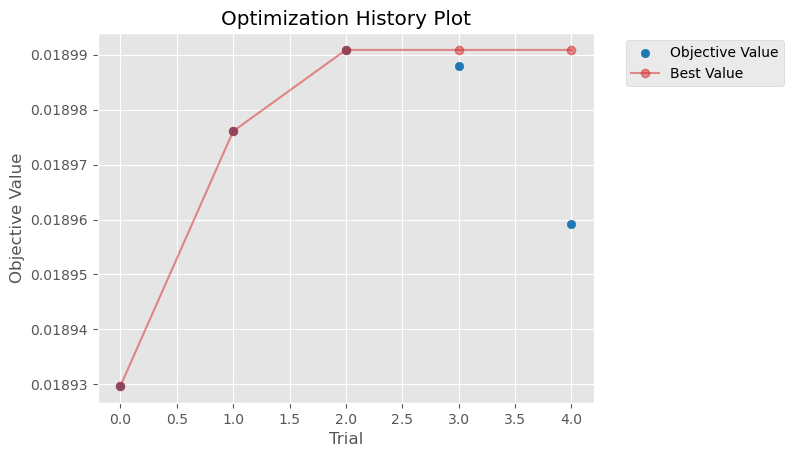

In [8]:
optuna.visualization.matplotlib.plot_param_importances(study)
optuna.visualization.matplotlib.plot_optimization_history(study)


In [8]:
topK = study.best_params['topK']
shrink = study.best_params['shrink']

In [9]:
recommender.fit(shrink=shrink, topK=topK)
result_df, _ = evaluator_test.evaluateRecommender(recommender)
result_df

Similarity column 24507 (100.0%), 9746.47 column/sec. Elapsed time 2.51 sec
EvaluatorHoldout: Processed 40019 (100.0%) in 22.40 sec. Users per second: 1786


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.047445,0.083182,0.078522,0.022413,0.038518,0.152281,0.076843,0.05915,0.318499,0.183666,...,0.961325,0.306181,0.961325,0.034047,8.834742,0.992594,0.078135,0.670384,3.663765,0.483962


In [23]:
recommender.fit(shrink=25, topK=100)
result_df, _ = evaluator_test.evaluateRecommender(recommender)
result_df

Similarity column 24507 (100.0%), 8393.73 column/sec. Elapsed time 2.92 sec
EvaluatorHoldout: Processed 41298 (100.0%) in 17.81 sec. Users per second: 2319


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.05209,0.070131,0.060658,0.024861,0.033144,0.16187,0.075501,0.056048,0.336409,0.199089,...,0.992049,0.333734,0.992049,0.109349,10.175265,0.995489,0.2169,0.754278,3.160259,0.35788


In [24]:
result_df.values

array([[0.05208968957333784, 0.07013148528657377, 0.06065759574058605,
        0.024860868007750926, 0.03314436273111939, 0.16187002598995737,
        0.0755008238311487, 0.056048095944744546, 0.3364085427865756,
        0.19908905423760756, 0.00470842148360571, 0.16035524993566766,
        0.9516265486533529, 0.995160350573242, 0.829681315542498,
        0.057534581956175786, 0.9986126412861631, 0.992048812126162,
        0.3337336952605155, 0.992048812126162, 0.10934904672415532,
        10.17526519561206, 0.9954890262361763, 0.21689982486372059,
        0.7542782950890405, 3.1602593341893654, 0.35787993474037655]],
      dtype=object)

In [24]:
recommender.fit(shrink=50, topK=80)
result_df, _ = evaluator_test.evaluateRecommender(recommender)
result_df

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1045.64 column/sec. Elapsed time 23.44 sec
EvaluatorHoldout: Processed 39996 (100.0%) in 26.08 sec. Users per second: 1534


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.016932,0.029289,0.027564,0.007106,0.012572,0.061196,0.027395,0.020978,0.143764,0.06588,...,0.960773,0.138125,0.960773,0.03585,9.069113,0.994058,0.082357,0.688252,3.357806,0.4904


In [55]:
recommender_try = ItemKNNCFRecommender(URM_train)
recommender_try.fit(topK=155, shrink=60.835282444940944)


result_df, _ = evaluator_validation.evaluateRecommender(recommender_try)
result_df

ItemKNNCFRecommender: URM Detected 3 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1076.01 column/sec. Elapsed time 22.78 sec
EvaluatorHoldout: Processed 38842 (100.0%) in 26.36 sec. Users per second: 1474


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.039218,0.082653,0.080303,0.017704,0.037006,0.128195,0.070728,0.052699,0.282298,0.149961,...,0.933051,0.263398,0.933051,0.031458,8.766627,0.992446,0.072189,0.665104,3.692853,0.481864


In [43]:
recommender_try = ItemKNNCFRecommender(URM_train)
recommender_try.fit(topK=150, shrink=60)


result_df, _ = evaluator_validation.evaluateRecommender(recommender_try)
result_df

ItemKNNCFRecommender: URM Detected 5 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1005.74 column/sec. Elapsed time 24.37 sec
EvaluatorHoldout: Processed 38984 (100.0%) in 27.82 sec. Users per second: 1401


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.039162,0.082337,0.080068,0.017838,0.03707,0.128873,0.070771,0.052598,0.280782,0.150903,...,0.936463,0.262942,0.936463,0.032166,8.79144,0.992498,0.073804,0.667122,3.680118,0.482355
